# Image orientation classification using MobileNet model

## To run this notebook you need:

0. Trained and estimated on images in 75x75/224x224 resolution and RGB format (training dataset format) (use C:\Users\User\DataScience\area51\notebooks\3_prepare_data.ipynb to prepare data) in order to make it comparable to the ResNet50 models




In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from src.models.imageorientation import OrientationEstimatorMobileNet, OrientationEstimatorResnet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from timeit import default_timer as timer
from tensorflow.keras.callbacks import Callback


# parameters
def initParams(imgResolution, model_name):
    
    imgResolution = imgResolution
    imgResStr = f"{imgResolution[0]}x{imgResolution[1]}"
    model_name = f"{imgResStr}_{model_name}"
    test_dataset_dir = rf"C:\Users\User\DataScience\area51\data_{imgResStr}\test_{imgResStr}"
    train_valid_dataset_dir = rf"C:\Users\User\DataScience\area51\data_{imgResStr}\train_val_{imgResStr}"

    basic_params = {  # 1. basics
                "img_resolution" : imgResolution,
                "model_name": model_name,
                "model_dir": rf"C:\Users\User\DataScience\area51\models\{model_name}",
                "data_dir": r"C:\Users\User\DataScience\area51\data\COVID-19_Radiography_Dataset",
                "train_valid_dataset_dir": train_valid_dataset_dir,
                "test_dataset_dir": test_dataset_dir,
                "test_dataset_desc": rf'''
    test dataset dir: {test_dataset_dir}
    dataset contains images:
    # rotation    :       image count
    # 0°          :       12
    # 180°        :       18
    # +90         :       15
    # -90         :       14
    
                                        ''',
    }
    # params for image_dataset_from_directory(...)
    data_loading_params = {
         
                        "directory": train_valid_dataset_dir,
                        "batch_size" : 32,
                        "seed": 42,                             # changed from 1 to 42
                        "label_mode": "categorical",            # for one-hot encoded labels
                        "color_mode": "rgb",                    # resNet/mobilenet require 3 channels otherwise needs to be trained from scratch 
                        "image_size": imgResolution,            # img_height, img_width
                        "shuffle": True,
                        "validation_split": 0.2,
                        "labels": "inferred",                   #derive from folder structure
    }
    # Compilation parameters for functional/sequential model.compile(...)
    model_params = {  
                        "input_shape": (imgResolution[0], 
                                        imgResolution[1], 3),     # input shape for the Input layer constructor (height, width, channels)
                        
                        # for model.compile()                      
                        "optimizer": 'adam',
                        "loss": "categorical_crossentropy",       #loss function for one-hot encoded/categorical labels
                        "metrics": ['accuracy'],
                        
                        # custom params for the model architecture                       
                        "layers_to_unfreeze": 0,
                        "exclude_augmentation": False, 
                        
    }

    return basic_params, data_loading_params, model_params

def initCallbacks():
    
    class TimingCallback(Callback):
                def __init__(self, logs={}):
                    self.logs=[]
                def on_epoch_begin(self, epoch, logs={}):
                    self.starttime = timer()
                def on_epoch_end(self, epoch, logs={}):
                    self.logs.append(timer()-self.starttime)

    time_callback = TimingCallback() 

    early_stopping = EarlyStopping(
                        patience=5,         # Wait for 5 epochs before applying
                        min_delta=0.01,     # If the loss function doesn't change by 1% after 5 epochs, either up or down, we stop
                        verbose=1,          # Display the epoch at which training stops
                        mode='min',
                    monitor='val_loss')

    reduce_learning_rate = ReduceLROnPlateau(
                                            monitor="val_loss",
                                            patience=2, # If val_loss stagnates for 3 consecutive epochs based on the min_delta value
                                            min_delta=0.02,
                                            factor=0.1,  # Reduce the learning rate by a factor of 0.1
                                            cooldown=2,  # epochs to wait before retrying 
                                            verbose=1)

    return [time_callback, early_stopping, reduce_learning_rate]



def init(model_name, basic_params):
    # initialize the estimator object
    # allow here the models to be initialized
    est = None
    if model_name == "aug_head1_resnet50":
        est = OrientationEstimatorResnet50(**basic_params)
    elif model_name == "aug_head1_mobnet":
        est = OrientationEstimatorMobileNet(**basic_params)
    
    return est

model loaded from C:\Users\User\DataScience\area51\models\224x224_aug_head1_resnet50\orientation_classifier_224x224_aug_head1_resnet50.keras
all parameters loaded from C:\Users\User\DataScience\area51\models\224x224_aug_head1_resnet50\all_parameters_224x224_aug_head1_resnet50.json
estimated results loaded from:  C:\Users\User\DataScience\area51\models\224x224_aug_head1_resnet50\estimated_orientation_224x224_aug_head1_resnet50.csv
model loaded from C:\Users\User\DataScience\area51\models\224x224_aug_head1_mobnet\orientation_classifier_224x224_aug_head1_mobnet.keras
all parameters loaded from C:\Users\User\DataScience\area51\models\224x224_aug_head1_mobnet\all_parameters_224x224_aug_head1_mobnet.json
estimated results loaded from:  C:\Users\User\DataScience\area51\models\224x224_aug_head1_mobnet\estimated_orientation_224x224_aug_head1_mobnet.csv
model accuracy, loss and learning rate: 224x224_aug_head1_resnet50 VS 224x224_aug_head1_mobnet


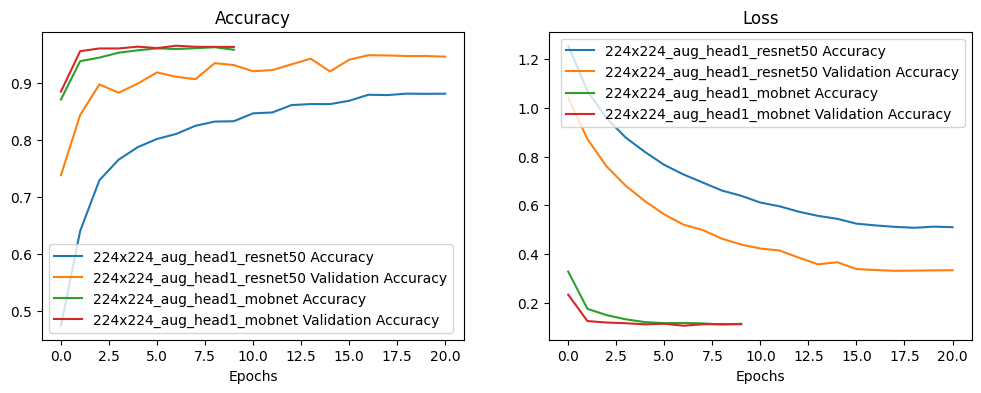

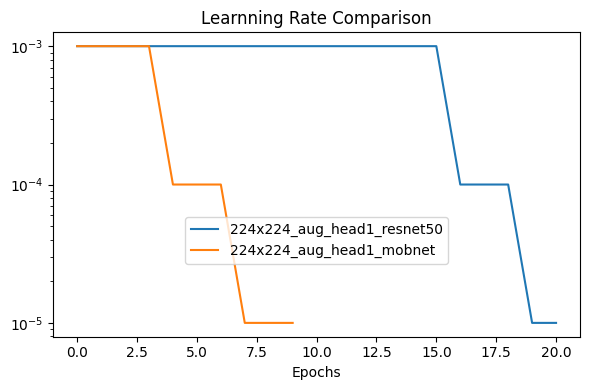

In [ ]:
# compare both models

datasetToEstim="data"
resolution =   (224, 224)

withAugmentation = True

mod1, mod2 = None, None

if withAugmentation:

    mod1 = "aug_head1_resnet50"
    mod2 = "aug_head1_mobnet"

else:

    mod1 = "noaug_head1_resnet50"
    mod2 = "noaug_head1_mobnet"

# only basic params differs between the models
basic_params_1, data_loading_params, model_params = initParams(resolution, mod1)
basic_params_2, _, _ = initParams(resolution, mod2)

# initialize the estimator objects for both models
est1 = init(mod1, basic_params_1)
est2 = init(mod2, basic_params_2)

# and load the trained models and the results
est1.loadTrainedModel()
est1.loadEstimatedData(datasetToEstim)
est2.loadTrainedModel()
est2.loadEstimatedData(datasetToEstim)

# compare the results of the two models
est1.compareToAnotherModel(est2)


model loaded from C:\Users\User\DataScience\area51\models\224x224_aug_head1_resnet50\orientation_classifier_224x224_aug_head1_resnet50.keras
all parameters loaded from C:\Users\User\DataScience\area51\models\224x224_aug_head1_resnet50\all_parameters_224x224_aug_head1_resnet50.json
model summary for: 224x224_aug_head1_resnet50


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 224, 224,  │          0 │ random_rotation_… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_1       │ (None, 224, 224,  │          0 │ random_translati… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ random_zoom_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

model accuracy & loss for: 224x224_aug_head1_resnet50


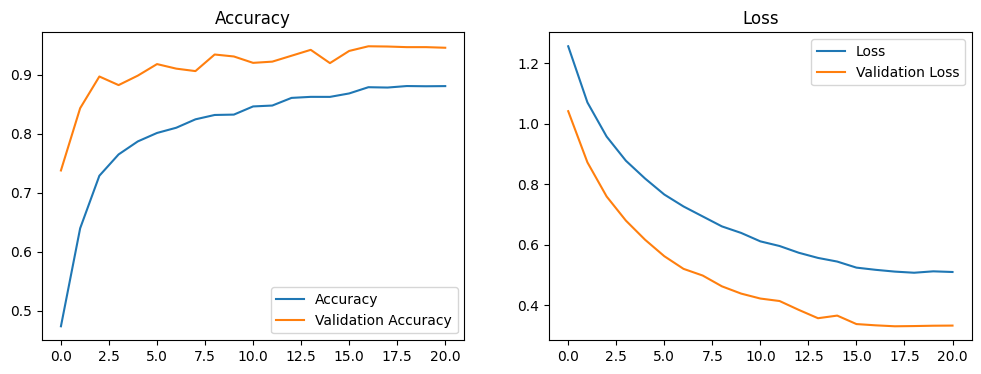

estimated results loaded from:  C:\Users\User\DataScience\area51\models\224x224_aug_head1_resnet50\estimated_orientation_224x224_aug_head1_resnet50.csv


In [ ]:

#----select scenario for the analysis----
# 1: train and estimate data from scratch, 
# 2: load trained model and estimate data with different dataset
# 3: use stored data for anylsis (e.g. plot metrics, show images with estimated orientation)
# 4: create true_oriented_dataset for confusion matrix and classification report 
scenario = 3

datasetToEstim="data"
resolutions =   [(224, 224)] #(75,75)

#models = ["aug_head1_resnet50", "aug_head1_mobnet"]
models = ["aug_head1_resnet50"]# "",
#models = ["aug_head1_mobnet"]

for imgResolution in resolutions:
    for model_name in models:
        
        # init specific parameters and estimator object
        basic_params, data_loading_params, model_params = initParams(imgResolution, model_name)
        est = init(model_name, basic_params)

        if scenario == 1: # Scenario 1: use this scenario for the full estimation cycle from data preparation-->training ... to checking/storing the results
        
            # initialize trainig/validation data and check it
            train_ds, val_ds = est.prepareTrainValidData(**data_loading_params)
            #est.checkTrainValDataStructure()

            # compile model 
            model = est.getCompiledModel(**model_params)

            #train
            clbcks = initCallbacks()
            model, history = est.train(target_val_acc=.98, epochs=30, callbacks=clbcks)
            
            # storings: model params
            est.storeTrainedModel() 
            est.saveAllParameters()
            
            # estimate/save and check the results
            df_estimated = est.estimateImageOrientation(datasetToEstim, save_to_csv=True) # estimate image orientation for specified dataset
            est.checkEstimatedData(df_estimated)

        elif scenario == 2: # use saved model to estimate data

            est.loadTrainedModel()
            df_estimated = est.estimateImageOrientation(datasetToEstim, save_to_csv=True) # estimate image orientation for specified dataset
            est.checkEstimatedData(df_estimated)
            est.showEstimatedImgOrientation(dataset=datasetToEstim, rotated_only=True, text_size=10, max_img_per_row=5)

        elif scenario == 3: # use saved model and other data
            
            est.loadTrainedModel()
            est.plotModelMetrics(include=["history", "summary"])
            est.loadEstimatedData(datasetToEstim)
            #est.showEstimatedImgOrientation(dataset=datasetToEstim, rotated_only=True, text_size=10, max_img_per_row=5)
        
        elif scenario == 4: # 4: create confusion matrix and classification report 
            
            from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
            import os
            import matplotlib.pyplot as plt
            from sklearn.metrics import classification_report

            df = est.loadEstimatedData(datasetToEstim)
            lables = ["0°", "180°", "+90°", "-90°"]

            # for quick test only
            if datasetToEstim == "test":
                df["true_orientation"] = df["Orientation"].copy()
                print(est._test_dataset_desc)

            # real data
            else:
                
                # set true orientation: all correct except originaly_rotated
                df["true_orientation"] = df["Orientation"].copy()
                originaly_rotated = os.listdir(r"C:\Users\User\DataScience\area51\224x224_originaly_rotated")
                df["true_orientation"] = "correct"

                # map
                file_rot_map = {
                    "COVID": "rotated_180",
                    "Lung_Opacity": "rotated_90",
                    "Normal": "rotated_minus_90"
                }

                def get_rotation_from_filename(filename):
                    for keyword, rotation in file_rot_map.items():
                        if keyword in filename:
                            return rotation
                    return "unknown"  # or None if no match found   
                
                

                # set rotation labels for truly rotated files
                for filename in originaly_rotated:
                    df.loc[df.Image == filename, "true_orientation"] = get_rotation_from_filename(filename)
                    
               
            # trully rotated images
            print(f"####truly rotated images total: {df[df["true_orientation"]!='correct'].shape[0]}")
            print(df[["Image", "Orientation", "Confidence", "true_orientation"]][df["true_orientation"] != 'correct'].head(10).to_string(index=False, line_width=10000), "\n")  
            
            #classification report 
            print(classification_report(df["true_orientation"], df["Orientation"], target_names=lables))

            # confusion matrix           
            cm = confusion_matrix(df["true_orientation"], df["Orientation"])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables,)
            disp.plot(cmap='Blues');
            
            plt.title("Confusion matrix")
            plt.show()
    
            est.showEstimatedImgOrientation(dataset=datasetToEstim, rotated_only=True, text_size=10, max_img_per_row=10)




        else:
            raise ValueError("Scenario not implemented yet")    


